In [71]:
import torch 
from stimulus import *
from BIRNN import *
import matplotlib.pyplot as plt 
from tqdm import trange

%matplotlib inline
memory_size = 128
in_emb = memory_size//4
mem_lay = 1
inputs_dim = 2
decisions = 3
typeCell = 'BEF'

sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
actor = ResMLP(memory_size, decisions, [64,64,64])

model = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, 
                    mem_lay=mem_lay, decisions=decisions, type = typeCell)

In [72]:
# load model
modelfname = f'./results_train/checkpoint_{typeCell}.pth'
state = torch.load(modelfname, map_location=torch.device('cpu'))
model.load_state_dict(state)
print('Model has',torch.sum(torch.tensor([p.numel() for p in model.parameters()])).item(), 'parameters')

Model has 135267 parameters


In [73]:
print(model.mem, model.sense, model.act, sep = '\n\n')

nBEFRC(
  (ff_im): Linear(in_features=32, out_features=768, bias=True)
  (ff_mm): Linear(in_features=128, out_features=640, bias=True)
)

ResMLP(
  (head): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (tail): Linear(in_features=64, out_features=32, bias=True)
  (activ): ReLU()
)

ResMLP(
  (head): Linear(in_features=128, out_features=64, bias=True)
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (tail): Linear(in_features=64, out_features=3, bias=True)
  (activ): ReLU()
)


In [ ]:
# weights of the linear layer that combines memory 'h' to produce bifurcation parameter 'a'
# if typeCell != 'GRU':
#     print(model.mem.ff_ha.weight.shape)
#     w_mat = model.mem.ff_ha.weight.detach()
#     plt.imshow(w_mat)
#     plt.show()

#     u,s,v = torch.linalg.svd(w_mat)
#     plt.scatter(torch.arange(len(s)), s)
#     plt.ylabel('Ordered singular values')
#     plt.show()

#     s[1:] = 0
#     plt.imshow(u@torch.diag(s)@v)

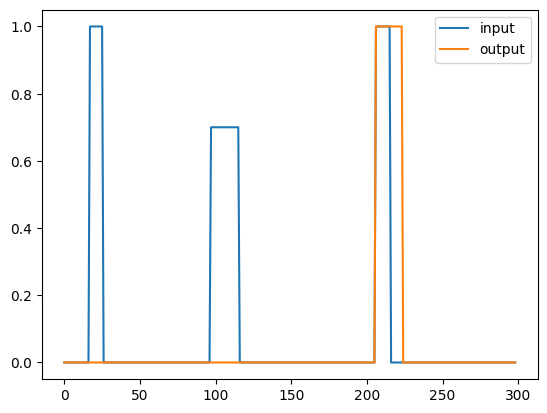

In [74]:
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
# d_i, d_o = stimG.concat_sim(d_i, d_o)

plt.plot(d_i[0], label = 'input')
plt.plot(d_o[0], label = 'output')
plt.legend()
plt.show()

In [ ]:
B, L = d_i.shape
mod_in = torch.zeros((B,L,2))
mod_in[...,0][d_i == 1] = 1
mod_in[...,1][d_i != 1] = d_i[d_i!=1]
plt.plot(mod_in[0,:,0], label = 'limit signals')
plt.plot(mod_in[0,:,1], label = 'pattern signal')
plt.legend()
plt.show()
# pred = model()

In [ ]:
dc = decode_choice(d_o)
dc.shape
plt.plot(dc[0])
plt.title('Expected probabilities through time')
plt.show()

with torch.no_grad():
    pred_c = model(mod_in)
    plt.plot(pred_c[0])
    plt.title('Predicted probabilities through time') 
    plt.show()
    plt.plot(dc[0] - pred_c[0])
    plt.show()

In [ ]:
# dive into memory

with torch.no_grad():
    if typeCell == 'BEF': 
        packed = model.forward(x=mod_in, debug_mem=True)
        a,b,c,d,e,pred_c, slow_var = packed
        print(model.sense.forward(mod_in).shape)
    elif typeCell == 'BRC':
        a,c,pred_c = model.forward(x=mod_in, debug_mem=True)
    else:
        pred_c = model.forward(x=mod_in, debug_mem=True)
    # model.mem.ff_ha.weight = torch.nn.Parameter(u@torch.diag(s)@v)
    # pred_pc = model.forward(x=mod_in, debug_mem=True)

for i in range(0,128,8):
    plt.clf()
    plt.plot(mod_in[0,:,1], label = 'signal')
    plt.plot(pred_c[0,:,i], label= 'memory')
    plt.plot(slow_var[0,:,i], label= 'slow_var')
    if typeCell != 'GRU':
        plt.plot(a[0,:,i], label= 'a')
        plt.plot(c[0,:,i], label= 'c')
        if typeCell == 'BEF':
            plt.plot(b[0,:,i], label= 'b')
            plt.plot(d[0,:,i], label= 'd')
            plt.plot(e[0,:,i], label= 'e')
    
    plt.legend()
    # plt.plot(pred_pc[0,:,i])
    plt.show()


### Generate animation of Phase plane as a function of timesteps for BEF cell

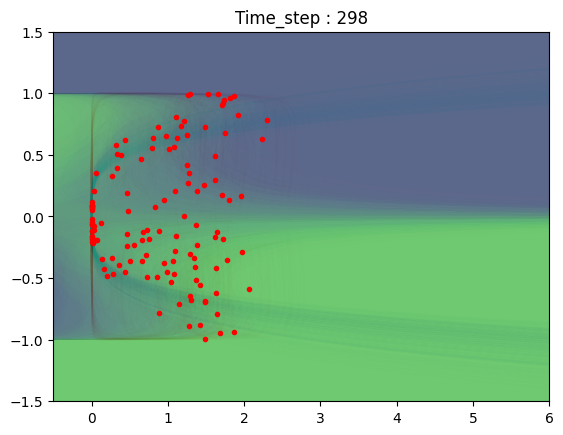

In [98]:
# Enable interactive plot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
def make_phase_portrait_animation(model,input_signal,neuron_nb):
    # model needs to have a BEF memory cell
    # input signal of shape (Batch size,sequence length,2) 
    # neuron number <nb memory cells
    fig, ax = plt.subplots()

    hfs = torch.meshgrid(torch.linspace(-1.5,1.5, 100), torch.linspace(-.5,6,100), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))

    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-1.5, 1.5)

    ## sense input 
    B, L, N = input_signal.shape  
    inputs = model.sense(input_signal.reshape((-1, N))).reshape((B,L,-1))

    ## define model
    def transition(hf, hs, pars):
        # size (B, V)
        a,b,c,d,e,x = pars['a'],pars['b'],pars['c'],pars['d'],pars['e'],pars['x']
        hfn = hf * (1-c) + c*torch.tanh(x + (a + b*hf**2 - hs)*hf) #0 input response
        hsn = hs*(1-d) + d*(e*hf)**4

        return hfn, hsn 

    def animate(frame_num):
        step_input = inputs[:,frame_num]
        in_emb  = model.mem.ff_im(step_input)
        _, _, _, _, _, neuron_inputs = in_emb.split(model.mem.mem_sz, 1)

        pars = {'a': a[0,frame_num,neuron_nb],
                'b': b[0,frame_num,neuron_nb],
                'c': c[0,frame_num,neuron_nb],
                'd': d[0,frame_num,neuron_nb],
                'e': e[0,frame_num,neuron_nb],
                'x': neuron_inputs[0,neuron_nb].item(),
                }

        hfn, hsn = transition(hfs[0], hfs[1], pars)
        ax.clear()
        ax.contourf(hfs[1], hfs[0], hfn - hfs[0], 0)
        ax.contour(hfs[1], hfs[0], hsn - hfs[1], 0)
        ax.set_title("neuron : "+ str(neuron_nb) + ", Time_step : " +  str(frame_num))
        
        # Plot trajectory
        ax.plot(slow_var[0, :frame_num, neuron_nb], pred_c[0, :frame_num, neuron_nb], 'r', alpha=0.5)
        ax.plot(slow_var[0, frame_num, neuron_nb], pred_c[0, frame_num, neuron_nb], 'ro')

    anim = FuncAnimation(fig, animate, frames=input_signal.shape[1],interval = 2,repeat = True, repeat_delay = 500)
    anim.save("phaseplot_animation_neuron" +str(neuron_nb) +".gif", writer='pillow')

def make_density_phase_portrait_animation(model,input_signal):
    # model needs to have a BEF memory cell
    # input signal of shape (Batch size,sequence length,2) 
    # neuron number <nb memory cells
    fig, ax = plt.subplots()

    hfs = torch.meshgrid(torch.linspace(-1.5,1.5, 100), torch.linspace(-.5,6,100), indexing = 'ij')
    hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))

    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-1.5, 1.5)

    ## sense input 
    B, L, N = input_signal.shape  
    inputs = model.sense(input_signal.reshape((-1, N))).reshape((B,L,-1))
    
    alpha = 1 / memory_size
    ## define model
    def transition(hf, hs, pars):
        # size (B, V)
        a,b,c,d,e,x = pars['a'],pars['b'],pars['c'],pars['d'],pars['e'],pars['x']
        hfn = hf * (1-c) + c*torch.tanh(x + (a + b*hf**2 - hs)*hf) #0 input response
        hsn = hs*(1-d) + d*(e*hf)**4

        return hfn, hsn 

    def animate(frame_num):
        step_input = inputs[:,frame_num]
        in_emb  = model.mem.ff_im(step_input)
        _, _, _, _, _, neuron_inputs = in_emb.split(model.mem.mem_sz, 1)
        ax.clear()
        for neuron in range(memory_size):
            pars = {'a': a[0,frame_num,neuron],
                    'b': b[0,frame_num,neuron],
                    'c': c[0,frame_num,neuron],
                    'd': d[0,frame_num,neuron],
                    'e': e[0,frame_num,neuron],
                    'x': neuron_inputs[0,neuron].item(),
                    }

            hfn, hsn = transition(hfs[0], hfs[1], pars)
            
            ax.contourf(hfs[1], hfs[0], hfn - hfs[0], 0, alpha = alpha)
            ax.contour(hfs[1], hfs[0], hsn - hfs[1], 0,alpha = alpha)
        ax.set_title("Time_step : " +  str(frame_num))
        
        # Plot trajectory
        for neuron in range(memory_size):
            ax.plot(slow_var[0, :frame_num, neuron], pred_c[0, :frame_num, neuron], 'r', alpha=0.5*alpha)
            ax.plot(slow_var[0, frame_num, neuron], pred_c[0, frame_num, neuron], 'ro',markersize=3)

    anim = FuncAnimation(fig, animate, frames=input_signal.shape[1],interval = 2,repeat = True, repeat_delay = 500)
    anim.save("densisty_phaseplot_animation.gif", writer='pillow')



#make_phase_portrait_animation(model,mod_in,69)
make_density_phase_portrait_animation(model,mod_in)

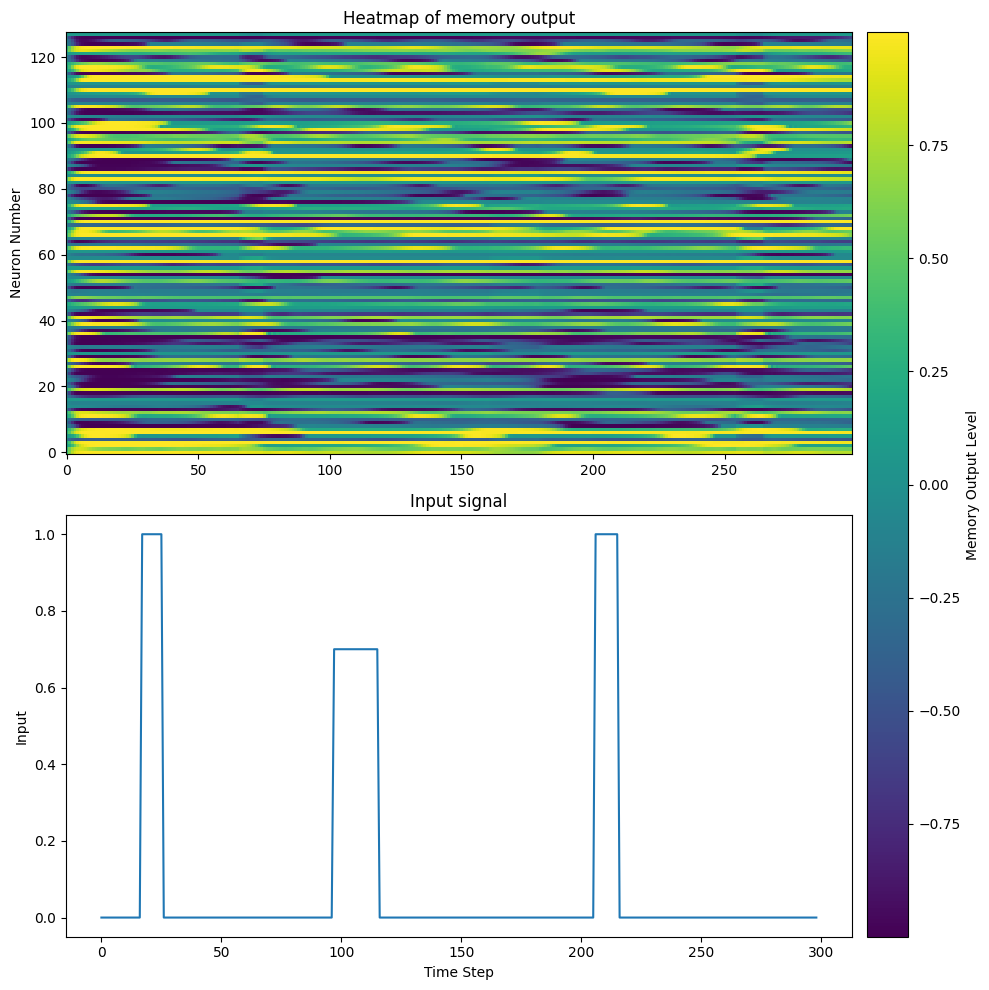

In [96]:
%matplotlib inline
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec

def plot_heatmap(pred_c, input_signal):
    # Get the shape of pred_c and input_signal
    num_timesteps, num_neurons = pred_c.shape

    # Create a meshgrid for the time steps and neuron numbers
    timesteps, neurons = np.meshgrid(range(num_timesteps), range(num_neurons))

    # Create subplots for both heatmaps
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[0.95, 0.05], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[:, 1])

    # Plot pred_c heatmap
    pcm1 = ax1.pcolormesh(timesteps, neurons, pred_c.T, shading='auto', cmap='viridis')
    ax1.set_ylabel('Neuron Number')
    ax1.set_title('Heatmap of memory output')

    # Plot mod_in heatmap
    ax2.plot(input_signal)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Input')
    ax2.set_title('Input signal')

    # Add colorbar
    cbar = fig.colorbar(pcm1, cax=cax)
    cbar.set_label('Memory Output Level')

    plt.tight_layout()
    plt.show()
    
plot_heatmap(pred_c[0,:,:],d_i[0])

